# Importing Franke's function, including a plot

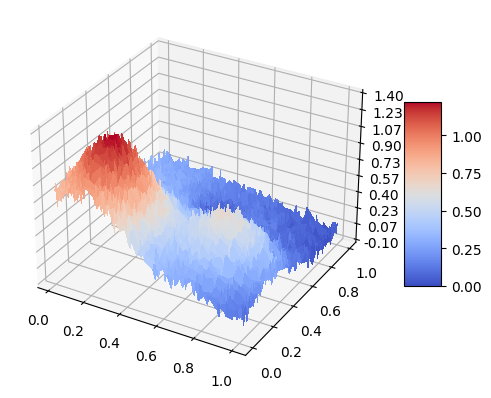

In [1]:
%reset -f

%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
import pandas as pd

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Generate the data
x = np.random.rand(100)
y = np.random.rand(100)
x = np.sort(x)
y = np.sort(y)

x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y) + 0.05*np.random.normal(0,1, x.shape)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Exercise a)

In this exercise, we only applied limited scaling of the data by removing the intercept. Removing the intercept mainly aims to make the code more in line with the following codes for the Ridge and Lasso Regression, where removing the intercept has an impact on the cost function.
Since our produced data is evenly distributed in the intervall [0,1), there is no need to identify outliers.

We perform splitting the data in test and train data once, and then apply the OLS fitting with polynomials for each degree. The uniformly splitting of the data allows us a better comparison of the MSEs later on.

By generating random input vectors x and y, we aim to avoid linear dependency of the columns of our Designmatrix, which would lead to singularities in the Hessian Matrix (?) X.T*X and thus problems of inverting said matrix.



In [2]:
def rsquare(y, ypredict):
    return 1-(np.sum((y-ypredict)**2)/np.sum((y-np.mean(y))**2))


def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/type_check.py:498: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = _nx.array(x, subok=True, copy=copy)


Text(0.5, 0, 'index of the beta in our vector')

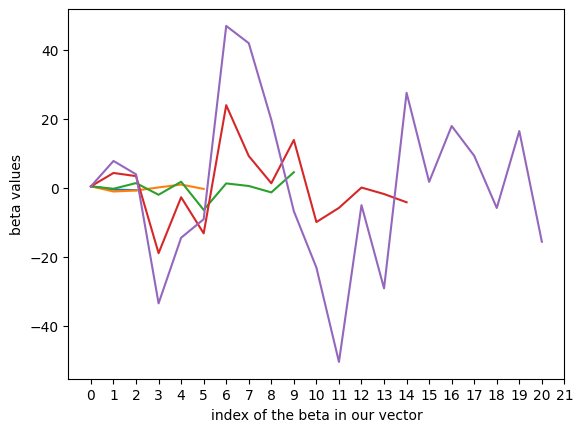

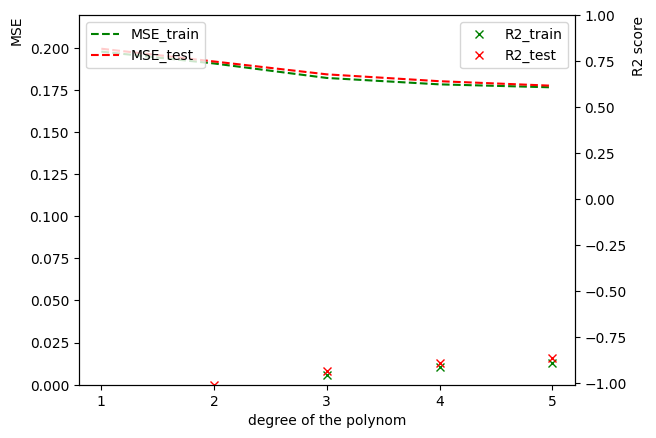

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import seaborn as sns

# max degree of the fitted polynomial
degree = 5

# setting up the Designmatrix
x = x.reshape(-1,1) #reshaping the meshgrid in two arrays
y = y.reshape(-1,1)
z = z.reshape(-1,1)

# credit: M. Hjorth-Jensen: Weekly Material, Week 35
def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

X = create_X(x,y,degree)

# Removing the intercept column, we later calculate the model's intercept
X = X[:,1:]

# splitting in train and test data
X_train, X_test, z_train, z_test = train_test_split( X, z, test_size=0.33, random_state=42)

# scaling the data, in this case we only center the data, thus we subtract the mean values from each column from every column entry
X_train_mean = np.mean(X_train,axis=0)
X_train_scaled = X_train - X_train_mean
X_test_scaled = X_test - X_train_mean
# we now calculate our model's intercept by using the expression from the lecture notes (M. Hjorth-Jensen: Notes on scaling with examples), which results from deriving the cost/loss function by beta0 and setting it to zero
# since our cost/loss function is convex this leads us to finding its minimum with respect to beta0
		# Dont I have to scale z test as well
		# Question: Why not: intercept = np.mean(z_train) - X_train_mean * beta but instead using the new mean of the scaled data
# The model intercept follows the equation z_scaler = np.mean(z_train) - np.mean(X_train_sc) * beta. Since we above centered our Designmatrix, the mean vector of X_train_sc equals the zero vector. Our equation reduces to:
z_scaler = np.mean(z_train)           
# dont scale the z


# OLS fitting

beta_list = []
MSE_train = np.zeros(degree)
MSE_test = np.zeros(degree)
rsqr_train = np.zeros(degree)
rsqr_test = np.zeros(degree)


for i in range(1, degree+1):
        c = int((i+2)*(i+1)/2)
        X_tilde = X_train_scaled[:,0:c-1]
        beta = np.linalg.pinv(X_tilde.T @ X_tilde) @ X_tilde.T @ z_train

        beta_list.append(list(beta))
		
        ypredict = X_tilde @ beta
        ypredict_test = X_test_scaled[:,0:c-1] @ beta

        MSE_train[i-1] = MSE(z_train, ypredict)
        MSE_test[i-1] = MSE(z_test, ypredict_test)
        rsqr_train[i-1]= rsquare(z_train, ypredict)
        rsqr_test[i-1]= rsquare(z_test, ypredict_test)



# plotting the MSE and R^2 - as well as beta - as functions of the polynomial degree
fig = plt.figure()

fig2, ax1 = plt.subplots()
plt.xlabel("degree of the polynom")
xax = np.arange(1, degree +1)
plt.xticks(xax)
ax2 = ax1.twinx()
ax2.set_ylim(np.min(rsqr_train)*0.9, 1)
ax1.set_ylim(0, np.max(MSE_test)*1.1)
ax1.plot(xax, MSE_train, 'g--', label='MSE_train')
ax1.plot(xax, MSE_test, 'r--', label='MSE_test')
ax2.plot(xax, rsqr_train, 'gx', label='R2_train')
ax2.plot(xax, rsqr_test, 'rx', label='R2_test')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_ylabel('MSE', loc='top')
ax2.set_ylabel('R2 score', loc='top')

# plot the beta
fig3 = fig.subplots()
xax2 = np.arange(0,len(X)+2)
fig3.set_xticks(xax2)
beta_list = np.nan_to_num(beta_list)
for i in range(len(beta_list)):
	fig3.plot(np.append(z_scaler, beta_list[i]))
fig3.set_ylabel("beta values")
fig3.set_xlabel("index of the beta in our vector")



# Exercise b) Ridge

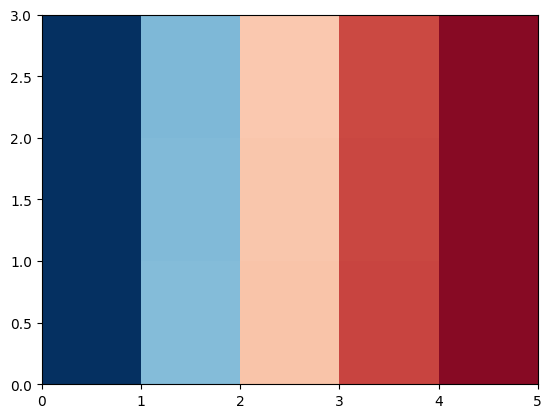

In [8]:
# We are using the same data, as well as splitting, as in a). This allows us a better comparison between our results from the OLS and the Ridge fitting.

lmb = np.linspace(-4, 0.05, 3) # We include lmb = 0, which equals the OLS fitting

beta_list = []
MSE_train = np.zeros((len(lmb),degree))
MSE_test = np.zeros((len(lmb),degree))
rsqr_train = np.zeros((len(lmb),degree))
rsqr_test = np.zeros((len(lmb),degree))

for j in range(len(lmb)):
    for i in range(1, degree+1):
            c = int((i+2)*(i+1)/2)
            X_tilde = X_train_scaled[:,0:c-1]
            beta = np.linalg.pinv(X_tilde.T @ X_tilde + lmb[j]*np.ones((len(X_tilde.T),len(X_tilde.T)))) @ X_tilde.T @ z_train
            beta_list.append(list(beta))
            
            ypredict = X_tilde @ beta
            ypredict_test = X_test_scaled[:,0:c-1] @ beta

            MSE_train[j, i-1] = MSE(z_train, ypredict)
            MSE_test[j, i-1] = MSE(z_test, ypredict_test)
            rsqr_train[j, i-1]= rsquare(z_train, ypredict)
            rsqr_test[j, i-1]= rsquare(z_test, ypredict_test)



# plotting the MSE and R^2 - as well as beta - as functions of the polynomial degree
# table

MSE_train_min = np.min(MSE_train)
MSE_train_max = np.max(MSE_train)

fig, ax = plt.subplots()
ax.pcolormesh(MSE_test, cmap='RdBu', vmin=MSE_train_min, vmax=MSE_train_max)
#ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
#ax.axis([x.min(), x.max(), y.min(), y.max()])
#fig.colorbar(c, ax=ax)


 
#plt.title("Heatmap with different color")
plt.show()


# Exercise c) Lasso Regression

In [5]:
from sklearn import linear_model

lmb = np.append([0],[0.0001*10**i for i in range(0,5)])
MSE_train_Lasso = np.zeros((len(lmb),degree))
MSE_test_Lasso = np.zeros((len(lmb),degree))
rsqr_train_Lasso = np.zeros((len(lmb),degree))
rsqr_test_Lasso = np.zeros((len(lmb),degree))


for j in range(len(lmb)):
    for i in range(1, degree+1):
        c = int((i+2)*(i+1)/2)
        X_tilde = X_train_scaled[:,0:c-1]

        RegLasso = linear_model.Lasso(lmb[i])
        RegLasso.fit(X_tilde,z_train)

        ypredict_Lasso = RegLasso.predict(X_tilde)
        ypredict_test_Lasso = RegLasso.predict(X_test_scaled[:,0:c-1])

        MSE_train_Lasso[j, i-1] = MSE(z_train, ypredict_Lasso)
        MSE_test_Lasso[j, i-1] = MSE(z_test, ypredict_test_Lasso)
        rsqr_train_Lasso[j, i-1] = MSE(z_train, ypredict_Lasso)
        rsqr_test_Lasso[j, i-1] = MSE(z_test, ypredict_test_Lasso)
        

# plotting the MSE and R^2 - as well as beta - as functions of the polynomial degree


NameError: name 'z_train_scaled' is not defined